In [1]:
import json
import plotly
import warnings
import numpy as np
import plotly.graph_objects as go

from glob import glob
from tabulate import tabulate
from scipy.stats import poisson
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')

In [2]:
def generate_tables(competition='Serie_A', max_goals=5, decimals=4):
    observed_data = np.zeros((max_goals + 1, max_goals + 1))
    home_goals, away_goals = list(), list()
    for file in glob(f'../../Data/results/processed/{competition}*games.json'):
        if '2025' in file: continue
        with open(file, 'r') as f: data = json.load(f)
        for game in data:
            result = data[game]['Result'].upper().split(' X ')
            score_h, score_a = int(result[0]), int(result[1])
            home_goals.append(score_h)
            away_goals.append(score_a)
            observed_data[min(score_a, max_goals), min(score_h, max_goals)] += 1

    home_mean, away_mean = np.mean(home_goals), np.mean(away_goals)
    home_probs = poisson(home_mean).pmf(range(max_goals + 1))
    away_probs = poisson(away_mean).pmf(range(max_goals + 1))
    home_probs[-1] = 1 - home_probs[:-1].sum()
    away_probs[-1] = 1 - away_probs[:-1].sum()
    theorical_data = np.outer(away_probs, home_probs)

    observed_data = np.round(observed_data / len(home_goals), decimals)
    theorical_data = np.round(theorical_data, decimals)
    print(f'Processed {len(home_goals)} games')

    return observed_data, theorical_data

In [3]:
def plot_heatmaps(observed_data, theorical_data, competition, colorscale):
    max_goals = observed_data.shape[0] - 1
    labels = [f'{i}' for i in range(max_goals)] + [f'{max_goals}+']
    z_min = min(np.min(theorical_data), np.min(observed_data))
    z_max = max(np.max(theorical_data), np.max(observed_data))

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Heatmap(z=theorical_data, x=labels, y=labels,
                             zmin=z_min, zmax=z_max, colorscale=colorscale,
                             text=[[f'{val:.2%}' for val in row] for row in theorical_data],
                             texttemplate='%{text}',
                             textfont={"size": 12},
                             showscale=True,
                             colorbar=dict(tickformat=',.0%')),
                  row=1, col=1)
    
    fig.add_trace(go.Heatmap(z=observed_data, x=labels, y=labels,
                             zmin=z_min, zmax=z_max, colorscale=colorscale,
                             text=[[f'{val:.2%}' for val in row] for row in observed_data],
                             texttemplate='%{text}',
                             textfont={"size": 12},
                             showscale=True,
                             colorbar=dict(tickformat=',.0%')),
                  row=1, col=2)

    tickvals = [*range(len(labels))]
    fig.update_xaxes(side='bottom', tickmode='array', tickvals=tickvals, ticktext=labels, title='Home goals', row=1, col=1)
    fig.update_xaxes(side='bottom', tickmode='array', tickvals=tickvals, ticktext=labels, title='Home goals', row=1, col=2)
    fig.update_yaxes(autorange='reversed', tickmode='array', tickvals=tickvals, ticktext=labels, title='Away goals', row=1, col=1)
    fig.update_yaxes(autorange='reversed', tickmode='array', tickvals=tickvals, ticktext=['' for _ in labels], title='', row=1, col=2)
    fig.update_layout(
        height=400, width=800, margin=dict(l=50, r=50, t=50, b=50),
        title=dict(text=competition.replace('_', ' ').replace('Serie', 'Série') + '<br>Goals distributions: theoretical vs. observed', x=0.5)
    )

    fig.write_image(f'../figures/{competition}.png'.replace(' ', ''))
    fig.show('png')

In [4]:
def plot_goals_heatmaps(observed_data, competition, colorscale):
    max_goals = observed_data.shape[0] - 1
    labels = [f'{i}' for i in range(max_goals)] + [f'{max_goals}+']
    z_min = np.min(observed_data)
    z_max = np.max(observed_data)

    fig = go.Figure()
    fig.add_trace(go.Heatmap(z=observed_data, x=labels, y=labels,
                             zmin=z_min, zmax=z_max, colorscale=colorscale,
                             text=[[f'{val:.2%}' for val in row] for row in observed_data],
                             texttemplate='%{text}',
                             textfont={"size": 12},
                             showscale=True,
                             colorbar=dict(tickformat=',.0%')))

    tickvals = [*range(len(labels))]
    fig.update_xaxes(side='bottom', tickmode='array', tickvals=tickvals, ticktext=labels, title='Home goals')
    fig.update_yaxes(autorange='reversed', tickmode='array', tickvals=tickvals, ticktext=labels, title='Away goals')
    fig.update_layout(
        height=400, width=600, margin=dict(l=50, r=50, t=50, b=50),
        title=dict(text=competition.replace('_', ' ').replace('Serie', 'Série') + '<br>Observed goals distribution', x=0.5)
    )

    fig.write_image(f'../figures/{competition}_observed_goals.png'.replace(' ', ''))
    fig.show('png')

In [5]:
def generate_1x2_stats(data):
    home_win = np.sum(np.triu(data, k=1))
    away_win = np.sum(np.tril(data, k=-1))
    draw = 1 - home_win - away_win

    return home_win, draw, away_win

def print_stats(observed_data, theorical_data, tablefmt):
    observed_percentage = generate_1x2_stats(observed_data)
    theorical_percentage = generate_1x2_stats(theorical_data)
    table = [['Observed', *observed_percentage], ['Theorical', *theorical_percentage]]
    headers = ['Data', 'Home (%)', 'Draw (%)', 'Away (%)']

    print(tabulate(table, headers, tablefmt=tablefmt, floatfmt='.2%'))

def visualize_competition(competition='Serie_A', max_goals=5, decimals=4, tablefmt='outline', colorscale=None):
    observed_data, theorical_data = generate_tables(competition, max_goals, decimals)
    print_stats(observed_data, theorical_data, tablefmt=tablefmt)
    plot_heatmaps(observed_data, theorical_data, competition, colorscale)
    plot_goals_heatmaps(observed_data, competition, colorscale)

Processed 4554 games
+-----------+------------+------------+------------+
| Data      |   Home (%) |   Draw (%) |   Away (%) |
+===========+============+============+============+
| Observed  |     48.41% |     26.88% |     24.71% |
| Theorical |     47.37% |     26.99% |     25.64% |
+-----------+------------+------------+------------+


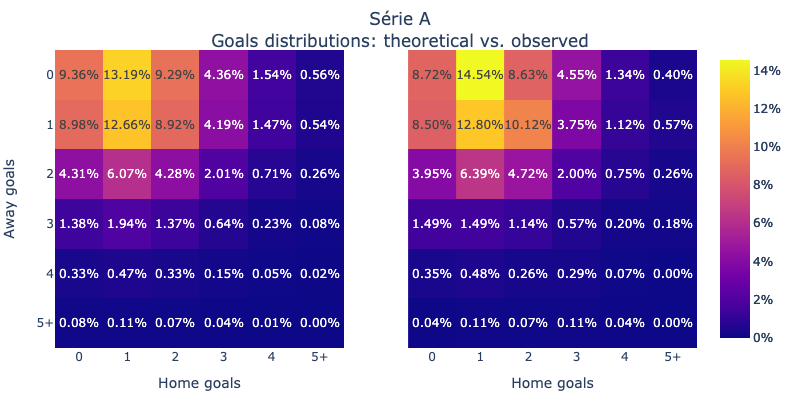

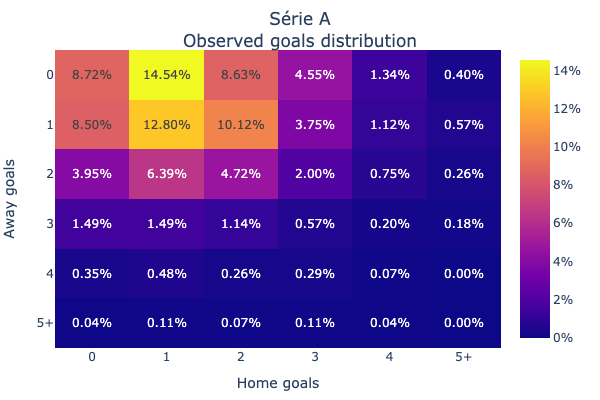

Processed 4556 games
+-----------+------------+------------+------------+
| Data      |   Home (%) |   Draw (%) |   Away (%) |
+===========+============+============+============+
| Observed  |     47.42% |     28.35% |     24.23% |
| Theorical |     46.24% |     27.98% |     25.78% |
+-----------+------------+------------+------------+


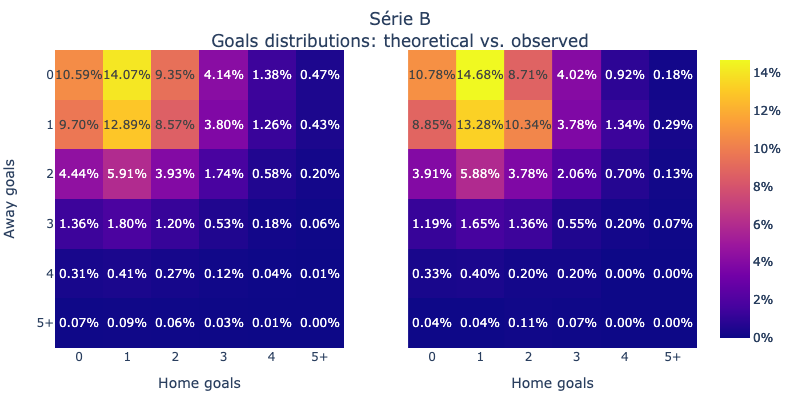

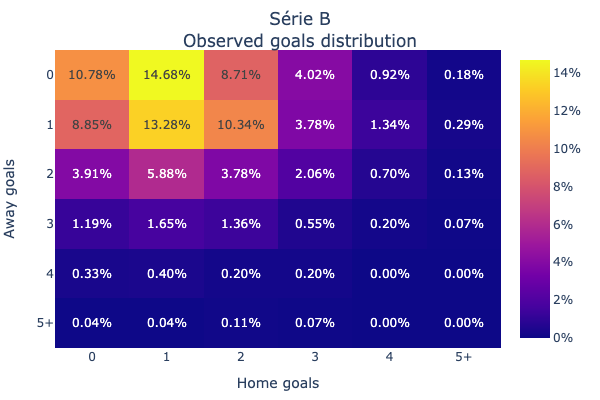

Processed 2436 games
+-----------+------------+------------+------------+
| Data      |   Home (%) |   Draw (%) |   Away (%) |
+===========+============+============+============+
| Observed  |     47.17% |     31.12% |     21.71% |
| Theorical |     47.87% |     27.50% |     24.63% |
+-----------+------------+------------+------------+


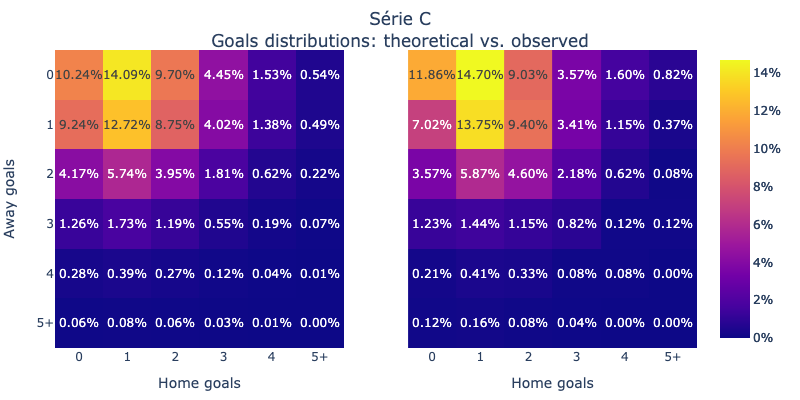

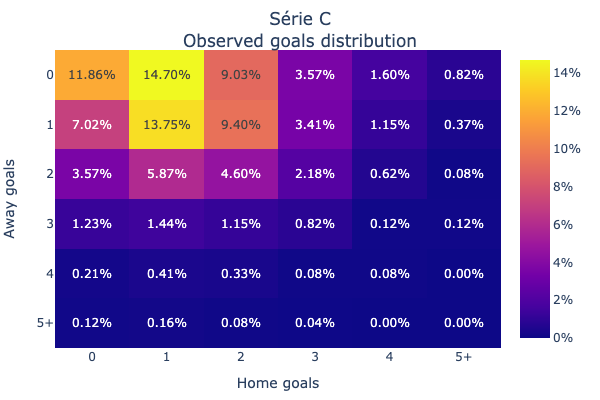

Processed 4201 games
+-----------+------------+------------+------------+
| Data      |   Home (%) |   Draw (%) |   Away (%) |
+===========+============+============+============+
| Observed  |     47.04% |     28.87% |     24.09% |
| Theorical |     48.40% |     26.57% |     25.03% |
+-----------+------------+------------+------------+


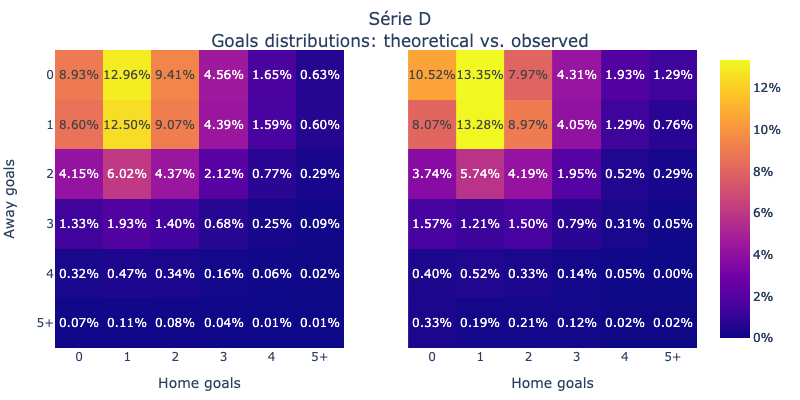

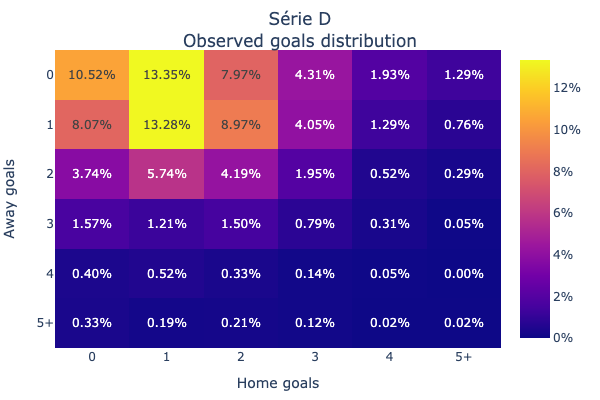

Processed 1603 games
+-----------+------------+------------+------------+
| Data      |   Home (%) |   Draw (%) |   Away (%) |
+===========+============+============+============+
| Observed  |     44.16% |     26.47% |     29.37% |
| Theorical |     42.72% |     27.55% |     29.73% |
+-----------+------------+------------+------------+


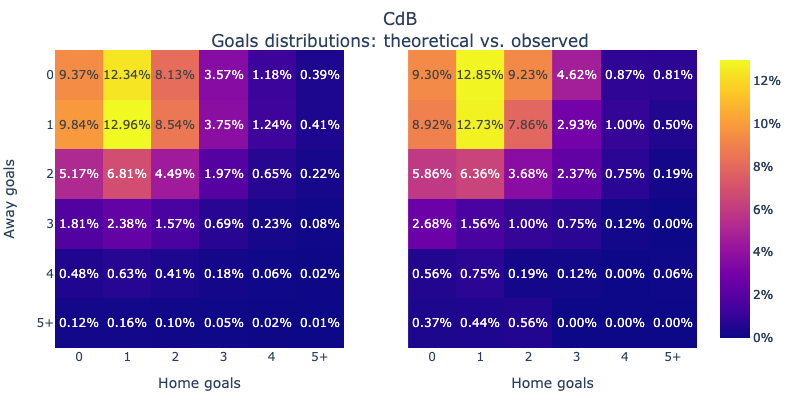

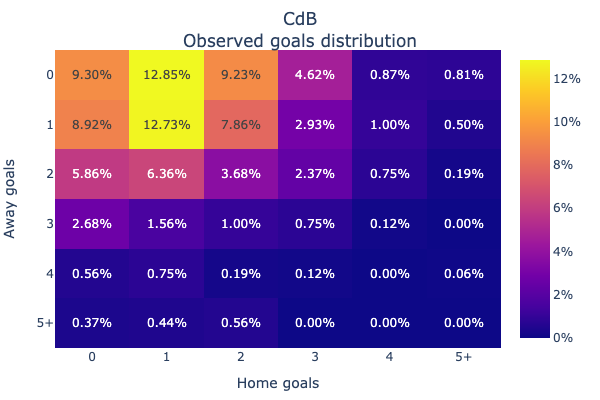

In [6]:
for competition in ['Serie_A', 'Serie_B', 'Serie_C', 'Serie_D', 'CdB']:
    visualize_competition(competition=competition, tablefmt='outline', colorscale=None)